### 04-Homework: Evaluation and Monitoring 
*In this homework, we'll evaluate the quality of our RAG system.*


Getting the data

Let's start by getting the dataset. We will use the data we generated in the module.
In particular, we'll evaluate the quality of our RAG system with ```gpt-4o-mini```

Read it:
```python
url = f'{github_url}?raw=1'
df = pd.read_csv(url)
```
We will use only the first 300 documents:
```python
df = df.iloc[:300]
```

In [1]:
import pandas as pd

base_url = 'https://github.com/DataTalksClub/llm-zoomcamp/blob/main'
relative_url = '04-monitoring/data/results-gpt4o-mini.csv'
docs_url = f'{base_url}/{relative_url}?raw=1'

url = f'{docs_url}?raw=1'
df = pd.read_csv(url)

In [2]:
df = df.iloc[:300]

In [4]:
df.iloc[10]

answer_llm     Yes, all sessions are recorded, so if you miss...
answer_orig    Everything is recorded, so you won’t miss anyt...
document                                                5170565b
question                    Are sessions recorded if I miss one?
course                                 machine-learning-zoomcamp
Name: 10, dtype: object

#### Q1. Getting the embeddings model

Now, get the embeddings model ```multi-qa-mpnet-base-dot-v1``` from the Sentence Transformer library<br>
*Note: this is not the same model as in HW3*

```python
from sentence_transformers import SentenceTransformer
embedding_model = SentenceTransformer(model_name)
```
Create the embeddings for the first LLM answer:
```python
answer_llm = df.iloc[0].answer_llm
```
What's the first value of the resulting vector?

-  [x] -0.42


In [3]:
from sentence_transformers import SentenceTransformer

model_name = 'multi-qa-mpnet-base-dot-v1'
model = SentenceTransformer(model_name)

You try to use a model that was created with version 3.0.0.dev0, however, your version is 2.7.0. This might cause unexpected behavior or errors. In that case, try to update to the latest version.





In [4]:
answer_llm = df.iloc[0].answer_llm

In [5]:
v = model.encode(answer_llm)

In [8]:
first_value = v[0]
print(first_value)

-0.42244655


#### Q2. Computing the dot product

Now for each answer pair, let's create embeddings and compute ```dot```product between them

We will put the results (scores) into the ```evaluations``` list

What's the 75% percentile of the score?

- [x] 31.67


In [13]:
import numpy as np

evaluations = []

for _, row in df.iterrows():
    answer_llm_embedding = model.encode(row.answer_llm)
    answer_human_embedding = model.encode(row.answer_orig)

    dot_product = np.dot(answer_llm_embedding, answer_human_embedding)
    evaluations.append(dot_product)

In [14]:
percentile_75 = np.percentile(evaluations, 75)
print(percentile_75)

31.67430877685547


#### Q3. Computing the cosine

From Q2, we can see that the results are not within the [0, 1] range. It's because the vectors coming from this model are not normalized.

So we need to normalize them.

To do it, we

    Compute the norm of a vector
    Divide each element by this norm

So, for vector v, it'll be v / ||v||

In numpy, this is how you do it:

```python
norm = np.sqrt((v * v).sum())
v_norm = v / norm
```

Let's put it into a function and then compute dot product between normalized vectors. This will give us cosine similarity

What's the 75% cosine in the scores?

- [x] 0.83



In [35]:
def normalize_vector(v):
    norm = np.sqrt((v * v).sum())
    v_norm = v / norm
    return v_norm

In [16]:
evaluations = []

for _, row in df.iterrows():
    answer_llm_embedding = model.encode(row.answer_llm)
    answer_human_embedding = model.encode(row.answer_orig)

    answer_llm_embedding_norm = normalize_vector(answer_llm_embedding)
    answer_human_embedding_norm = normalize_vector(answer_human_embedding)

    cosine_similarity = np.dot(answer_llm_embedding_norm, answer_human_embedding_norm)
    evaluations.append(cosine_similarity)

In [17]:
percentile_75 = np.percentile(evaluations, 75)
print(percentile_75)

0.8362348973751068


#### Q4. Rouge

Now we will explore an alternative metric - the ROUGE score.
This is a set of metrics that compares two answers based on the overlap of n-grams, word sequences, and word pairs.
It can give a more nuanced view of text similarity than just cosine similarity alone.
We don't need to implement it ourselves, there's a python package for it:

```python
pip install rouge
```
(The latest version at the moment of writing is 1.0.1)

Let's compute the ROUGE score between the answers at the index 10 of our dataframe (doc_id=5170565b)

```python
from rouge import Rouge
rouge_scorer = Rouge()
```
```python
scores = rouge_scorer.get_scores(r['answer_llm'], r['answer_orig'])[0]
```

There are three scores: rouge-1, rouge-2 and rouge-l, and precision, recall and F1 score for each.

    rouge-1 - the overlap of unigrams,
    rouge-2 - bigrams,
    rouge-l - the longest common subsequence

What's the F score for rouge-1?

- [x] 0.45


In [18]:
from rouge import Rouge

In [19]:
rouge_scorer = Rouge()

In [20]:
r = df.iloc[10]

In [21]:
r

answer_llm     Yes, all sessions are recorded, so if you miss...
answer_orig    Everything is recorded, so you won’t miss anyt...
document                                                5170565b
question                    Are sessions recorded if I miss one?
course                                 machine-learning-zoomcamp
Name: 10, dtype: object

In [22]:
scores = rouge_scorer.get_scores(r['answer_llm'], r['answer_orig'])[0]

In [23]:
f_score_rouge1 = scores['rouge-1']['f']
print(f_score_rouge1)

0.45454544954545456


#### Q5. Average rouge score

Let's compute the average between *rouge-1, rouge-2* and *rouge-l* for the same record from Q4

- [x] 0.35

In [26]:
average_rouge_score = (f_score_rouge1 + f_score_rouge2 + f_score_rougel) / 3
print(average_rouge_score)

0.35490034990035496


#### Q6. Average rouge score for all the data points

Now let's compute the score for all the records

```python
rouge_1 = scores['rouge-1']['f']
rouge_2 = scores['rouge-2']['f']
rouge_l = scores['rouge-l']['f']
rouge_avg = (rouge_1 + rouge_2 + rouge_l) / 3
```

And create a dataframe from them

What's the agerage rouge_2 across all the records?

-  [x] 0.20 

In [28]:
for _, row in df.iterrows():
    scores = rouge_scorer.get_scores(row['answer_llm'], row['answer_orig'])[0]
    
    rouge_1 = scores['rouge-1']['f']
    rouge_2 = scores['rouge-2']['f']
    rouge_l = scores['rouge-l']['f']
    rouge_avg = (rouge_1 + rouge_2 + rouge_l) / 3
    
    rouge_1_scores.append(rouge_1)
    rouge_2_scores.append(rouge_2)
    rouge_l_scores.append(rouge_l)
    rouge_avg_scores.append(rouge_avg)

rouge_scores_df = pd.DataFrame({
    'rouge_1': rouge_1_scores,
    'rouge_2': rouge_2_scores,
    'rouge_l': rouge_l_scores,
    'rouge_avg': rouge_avg_scores
})

average_rouge_2 = rouge_scores_df['rouge_2'].mean()
print(average_rouge_2)

0.20696501983423318


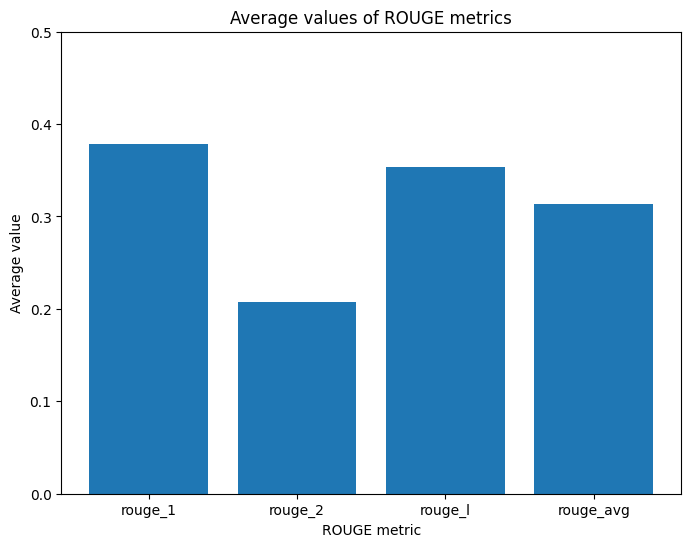

In [34]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 6))
plt.bar(rouge_scores_df.columns, rouge_scores_df.mean())
plt.xlabel('ROUGE metric')
plt.ylabel('Average value')
plt.title('Average values of ROUGE metrics')
plt.ylim(0, 0.5) 
plt.show()